In [1]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
from sklearn.metrics import roc_curve, auc

import os
os.makedirs('out', exist_ok=True)

In [2]:
from old_gat_withweight import build_samples,GATWeightedClassifier,train,evaluate,run_cross_validation

In [3]:
germline_input = np.load('./data/tcga_germlinevariants_7861patients.npy', allow_pickle= True).item()
germline_input.keys()

dict_keys(['gvariant_status', 'gene', 'edge', 'dependency_score', 'pli', 'sh', 'age', 'patients', 'cancer'])

In [4]:
import itertools
cancers = pd.Series(germline_input['cancer']).value_counts().index
combinations = list(itertools.combinations(cancers[:10], 2))

/home/jovyan/GRIP-GNN/old_gat_withweight.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge, dtype=torch.long)



===== Fold 1 =====
Epoch 10: Loss = 0.3523
Epoch 20: Loss = 0.3540
Epoch 30: Loss = 0.3589
Fold 1 - Accuracy: 0.8254, AUC: 0.8998, F1: 0.8593

===== Fold 2 =====
Epoch 10: Loss = 0.3551
Epoch 20: Loss = 0.3577
Epoch 30: Loss = 0.3502
Fold 2 - Accuracy: 0.8286, AUC: 0.8943, F1: 0.8657

===== Fold 3 =====
Epoch 10: Loss = 0.3951
Epoch 20: Loss = 0.3799
Epoch 30: Loss = 0.3864
Fold 3 - Accuracy: 0.8730, AUC: 0.9484, F1: 0.9000

===== Fold 4 =====
Epoch 10: Loss = 0.3653
Epoch 20: Loss = 0.3560
Epoch 30: Loss = 0.3628
Fold 4 - Accuracy: 0.8567, AUC: 0.9169, F1: 0.8855

Mean CV Results - AUC: 0.9149, F1: 0.8776


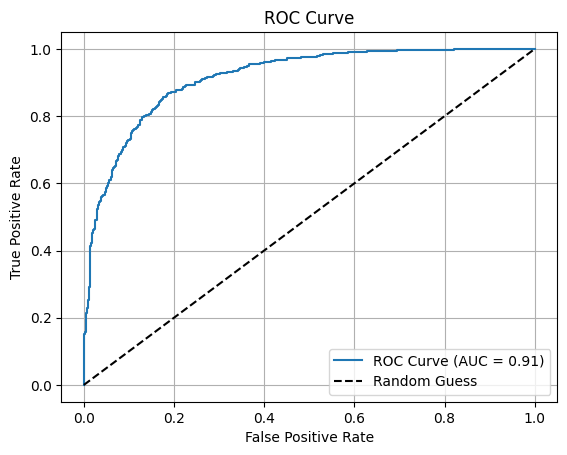

/home/jovyan/GRIP-GNN/old_gat_withweight.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index = torch.tensor(edge, dtype=torch.long)



===== Fold 1 =====
Epoch 10: Loss = 0.3711
Epoch 20: Loss = 0.3821
Epoch 30: Loss = 0.3787
Fold 1 - Accuracy: 0.8095, AUC: 0.8832, F1: 0.8477

===== Fold 2 =====
Epoch 10: Loss = 0.3818
Epoch 20: Loss = 0.3709
Epoch 30: Loss = 0.3926
Fold 2 - Accuracy: 0.7873, AUC: 0.8770, F1: 0.8251

===== Fold 3 =====
Epoch 10: Loss = 0.4260
Epoch 20: Loss = 0.4071
Epoch 30: Loss = 0.4094
Fold 3 - Accuracy: 0.8762, AUC: 0.9435, F1: 0.9046

===== Fold 4 =====
Epoch 10: Loss = 0.4010


In [ ]:
for g,s in combinations:
    cancer_index = np.where(pd.Series(germline_input['cancer']) == g)
    control_index = np.where(pd.Series(germline_input['cancer']) == s)
    all_index = np.concatenate((cancer_index[0], control_index[0]))
    
    g_input = np.concatenate((germline_input['gvariant_status'][cancer_index],germline_input['gvariant_status'][control_index]),axis = 0)
    edge_input = germline_input['edge']
    label = [1] * len(cancer_index[0]) + [0] * len(control_index[0]) 
    
    for weight_score in [None, 'dependency_score', 'pli','sh']:
        if weight_score is None:
            input_object = build_samples(g_input, 
                            edge_input, 
                            label,
                            None
                            )
        else:
            input_object = build_samples(g_input, 
                            edge_input, 
                            label,
                            germline_input[weight_score].fillna(0.0).to_numpy(dtype=float)
                            )
        #pos_weight_tensor = torch.tensor([186 / 784], device='cpu')
        output = run_cross_validation(input_object, in_channels=1, pos_weight = None, epochs=30, folds = 4, task = f'{g}_vs_{s}')
        np.save(f'./out/{g}_vs_{s}_weight_{str(weight_score)}_prediction_results.npy', output, allow_pickle=True)

        true_label = []
        pred_scores = []
        predictions = []
        for i in output:
            true_label = true_label + i['true']
            pred_scores = pred_scores + i['scores']
            predictions = predictions + i['predictions']

        
        # Example data: true labels and prediction scores
        y_true = [0, 0, 1, 1]
        y_scores = [0.1, 0.4, 0.35, 0.8]  # predicted probabilities for the positive class
        
        # Calculate ROC curve values
        fpr, tpr, thresholds = roc_curve(true_label, pred_scores)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig(f'./out/{g}_vs_{s}_weight_{str(weight_score)}_test_roc.png', dpi=150, bbox_inches='tight')
        plt.show()